# Cross-check of EXO-19-009 searching for $pp\rightarrow pp ZZ \rightarrow pp + 2\ell + X$

Using the di-muon final state and the final ntuples of EXO-19-009 we select events in data and search for a resonant Z in the missing mass peak.

In [3]:
%load_ext autoreload
%autoreload 2

import os
import ROOT
import PyRDF
import pandas as pd
import numpy as np
import sys
sys.path.append(os.path.abspath('../ewk-vjj'))
from snippets.plot_helpers import *
from snippets.sample_helpers import mergeSnapshotChunksToDataFrames
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use([hep.style.ROOT, hep.style.firamath])
import datetime
import pickle

url='/eos/cms/store/cmst3/user/psilva/ExclusiveAna/final/2017_unblind_multi/analysis_1exc'
files=[os.path.join(url,f) for f in os.listdir(url) if 'DoubleMuon' in f]

_outdir='/eos/user/p/psilva/data/ppszx/ppZZ'
os.system('mkdir -p {}/Chunks'.format(_outdir))
_plotsdir='/eos/user/p/psilva/www/EXO-19-009/ppZZ/{}'.format(datetime.datetime.now().strftime('%Y%b%d'))
os.system('mkdir -p {}'.format(_plotsdir))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


0

## Pre-select the events

We run twice the selection: one for data, the other for background (using combinatorial mixing model)
We select di-muon events with $p_{T}(\ell_1)>30$ GeV, $p_{T}(\ell_2)>20$ GeV, $m_{miss}<250$ GeV.
The other preselection cuts for the quality of the protons and muons have been applied before.
You can skip this step if the final dataframes have been already stored in .parquet format.
If you have to run please connect to spark in advance (otherwise switch to local running below).

In [ ]:
def select(files,out_file,doBkg=False,local=True):
    
    """
    select the events using RDataFrame
    returns a pandas DataFrame with the final information relevant for the cross check
    """

    if local:
        ROOT.ROOT.EnableImplicitMT()
        PyRDF.use('local')
    else:
        PyRDF.use('spark', {'npartitions':20})
        files = ['root://eosuser.cern.ch/{}'.format(x) if x.find('root:')<0 else x for x in files]
        out_file='root://eosuser.cern.ch/{}'.format(out_file)
    
    #define the selections and branches with an RDataFrame
    rdf = PyRDF.RDataFrame("data", files)

    cut =  'cat==169 && l1pt>30 && l2pt>20'
    cut += ' && csi1>0 && csi2>0 && mmiss>0 && mmiss<250'
    cut += ' && mixType=={}'.format(1 if doBkg else 0)
    print('Preselect {} files with the following cuts: {}'.format(len(files),cut))
    rdf=rdf.Filter(cut,'presel')

    #save snapshot
    columns  = ['wgt','bosonpt','protonCat','xangle','njets','nvtx','nch']
    columns += ['mmiss','mpp','ypp','csi1','csi2']
    snapshot_branches = ROOT.vector('string')()
    for b in columns:
        snapshot_branches.push_back(b)
    rdf.Snapshot('data', out_file, snapshot_branches)
    
    #disable the implicit multi-threading if it has been used
    if local:
        ROOT.ROOT.DisableImplicitMT()
        
local=False
for proc,doBkg in [('data',False),('bkg','True')]:
    out_file=os.path.join(_outdir,'Chunks/{}.root'.format(proc))
    select(files,out_file,doBkg=doBkg,local=local)

In [ ]:
#merge the results
mergeSnapshotChunksToDataFrames(_outdir+'/Chunks',_outdir,convertToPandas=True)
print(os.listdir(_outdir))

## Fill histograms

The missing mass histograms are filled for different categories in data and background.
You can skip this step if the histograms have been previously stored in pickle files.

In [8]:
def fillHistos(url):
    
    """
    fills histograms for different categories
    {proton-reco: multi-multi, multi-single} x {exclusivity requirements: inclusive, jet veto}
    """
    
    df=pd.read_hdf(url,key='data')
    
    mm=(df['protonCat']==1)
    ms=(df['protonCat']==2) | (df['protonCat']==3)
    exc=(df['njets']==0)
    lowpu=(df['nvtx']<20)
    lowpt=(df['bosonpt']<40)
    highpt=(df['bosonpt']>40)
    
    histos={}
    for cat,mask in [ ('mminc', mm ),
                      ('msinc', ms ),
                      ('mmexc', mm & exc),
                      ('msexc', ms & exc),
                      ('mminclowpu', mm & lowpu),
                      ('msinclowpu', ms & lowpu),
                      ('mmexclowpu', mm & exc & lowpu),
                      ('msexclowpu', ms & exc & lowpu ),
                      ('mminclowpt', mm & lowpt),
                      ('msinclowpt', ms & lowpt),
                      ('mmexclowpt', mm & exc & lowpt),
                      ('msexclowpt', ms & exc & lowpt ),
                      ('mminchighpt', mm & highpt),
                      ('msinchighpt', ms & highpt),
                      ('mmexchighpt', mm & exc & highpt),
                      ('msexchighpt', ms & exc & highpt ),]:
        label  = r'multi-multi' if 'mm' in cat else 'multi-single'
        label += r' N$_{vtx}$<20' if 'lowpu' in cat else ''
        label += r' p$_{T}(Z)$<40' if 'lowpt' in cat else ''
        label += r' p$_{T}(Z)$>40' if 'highpt' in cat else ''
        label += r' (inc.)' if 'inc' in cat else '(N$_{jets}$=0)'
        x=df[mask]['mmiss']
        histos[cat]= {'histo':countInHistogram(x=x,w=None, bins=np.linspace(0,200,100)),
                      'label':label,
                      'xlabel':r'Missing mass [GeV]'}
        #x=df[mask]['mpp']
        #histos[cat]= {'histo':countInHistogram(x=x,w=None, bins=np.linspace(250,400,100)),
        #              'label':label,
        #              'xlabel':r'Di-proton mass [GeV]'}
                
    del df
        
    return histos

#fill and save in a pickle file
for proc in ['data','bkg']:
    h = fillHistos(os.path.join(_outdir,'{}.h5'.format(proc)))
    with open(os.path.join(_outdir,'{}_histos.pck'.format(proc)),'wb') as fout:
        pickle.dump(h,fout,pickle.HIGHEST_PROTOCOL)

## Results

The resulting missing mass distributions are shown below

In [6]:
histos={}
for proc in ['data','bkg']:
    with open(os.path.join(_outdir,'{}_histos.pck'.format(proc)),'rb') as fin:
        histos[proc]=pickle.load(fin)

hist_list=sorted(list(histos['data'].keys()))
print('Plotting:',hist_list)

#loop to draw all histograms
for key in hist_list:
    
    datah             = histos['data'][key]['histo']
    xlabel            = histos['data'][key]['xlabel']
    ptitle            = histos['data'][key]['label']
    x,cts,unc         = datah
    _,bkg_cts,bkg_unc = histos['bkg'][key]['histo']

    #normalize background using mmiss>150 GeV
    idx=np.abs(x-150).argmin()
    kfact=np.sum(cts[idx:])/np.sum(bkg_cts[idx:])
    final_bkg=(x,bkg_cts*kfact,(bkg_unc*kfact).mean(axis=1))
    
    #do final plot
    showComparisonPlot(data=datah,         data_label='Data',
                       stack=[final_bkg],  stack_labels=['Background'],
                       logy=False,         logx=False,
                       xlabel=xlabel,      ylabel='Events', 
                       #xran=(91-25,91+25),
                       ptitle=ptitle,
                       legendFontSize=16,
                       outname=os.path.join(_plotsdir,'mmiss_{}'.format(key)))


Plotting: ['mmexc', 'mmexchighpt', 'mmexclowpt', 'mmexclowpu', 'mminc', 'mminchighpt', 'mminclowpt', 'mminclowpu', 'msexc', 'msexchighpt', 'msexclowpt', 'msexclowpu', 'msinc', 'msinchighpt', 'msinclowpt', 'msinclowpu']


<ipython-input-6-459c0dfa6e41>:20: RuntimeWarning: invalid value encountered in long_scalars
  kfact=np.sum(cts[idx:])/np.sum(bkg_cts[idx:])
/cvmfs/sft.cern.ch/lcg/views/LCG_100/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
'texgyreheros-bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-italic.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


Plot saved in /eos/user/p/psilva/www/EXO-19-009/ppZZ/2021Sep21/mmiss_mmexc.{png,pdf}


'texgyreheros-bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-italic.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


Plot saved in /eos/user/p/psilva/www/EXO-19-009/ppZZ/2021Sep21/mmiss_mmexchighpt.{png,pdf}


'texgyreheros-bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-italic.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


Plot saved in /eos/user/p/psilva/www/EXO-19-009/ppZZ/2021Sep21/mmiss_mmexclowpt.{png,pdf}


'texgyreheros-bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-italic.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


Plot saved in /eos/user/p/psilva/www/EXO-19-009/ppZZ/2021Sep21/mmiss_mmexclowpu.{png,pdf}


'texgyreheros-bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-italic.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


Plot saved in /eos/user/p/psilva/www/EXO-19-009/ppZZ/2021Sep21/mmiss_mminc.{png,pdf}


'texgyreheros-bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-italic.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


Plot saved in /eos/user/p/psilva/www/EXO-19-009/ppZZ/2021Sep21/mmiss_mminchighpt.{png,pdf}


'texgyreheros-bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-italic.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


Plot saved in /eos/user/p/psilva/www/EXO-19-009/ppZZ/2021Sep21/mmiss_mminclowpt.{png,pdf}


'texgyreheros-bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-italic.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


Plot saved in /eos/user/p/psilva/www/EXO-19-009/ppZZ/2021Sep21/mmiss_mminclowpu.{png,pdf}


'texgyreheros-bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-italic.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


Plot saved in /eos/user/p/psilva/www/EXO-19-009/ppZZ/2021Sep21/mmiss_msexc.{png,pdf}


'texgyreheros-bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-italic.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


Plot saved in /eos/user/p/psilva/www/EXO-19-009/ppZZ/2021Sep21/mmiss_msexchighpt.{png,pdf}


'texgyreheros-bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-italic.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


Plot saved in /eos/user/p/psilva/www/EXO-19-009/ppZZ/2021Sep21/mmiss_msexclowpt.{png,pdf}


'texgyreheros-bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-italic.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


Plot saved in /eos/user/p/psilva/www/EXO-19-009/ppZZ/2021Sep21/mmiss_msexclowpu.{png,pdf}


'texgyreheros-bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-italic.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


Plot saved in /eos/user/p/psilva/www/EXO-19-009/ppZZ/2021Sep21/mmiss_msinc.{png,pdf}


'texgyreheros-bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-italic.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


Plot saved in /eos/user/p/psilva/www/EXO-19-009/ppZZ/2021Sep21/mmiss_msinchighpt.{png,pdf}


'texgyreheros-bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-italic.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


Plot saved in /eos/user/p/psilva/www/EXO-19-009/ppZZ/2021Sep21/mmiss_msinclowpt.{png,pdf}


'texgyreheros-bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-italic.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


Plot saved in /eos/user/p/psilva/www/EXO-19-009/ppZZ/2021Sep21/mmiss_msinclowpu.{png,pdf}


In [33]:
t=ROOT.TChain('analysis/data')
vb,vbtitle='ZZ',r'pp$\rightarrow$ZZ'
#vb,vbtitle='Zgamma',r'pp$\rightarrow$Z$\gamma$'

t.AddFile('/eos/user/p/psilva/data/ppszx/MC13TeV_MG5_{}_box_UL17.root'.format(vb))
ngen,nselz,nsel=0.,0.,0.
events=[]
print(t.GetEntries(),'events available')
for i in range(t.GetEntries()):
    t.GetEntry(i)
    ngen+=1
    
    #lepton selection
    leptons={11:[],13:[],22:[]}
    for ig in range(t.ng):
        gid=abs(t.g_id[ig])
        if not gid in [11,13,22] : continue
        leptons[gid].append(ROOT.TLorentzVector(0,0,0,0))
        leptons[gid][-1].SetPtEtaPhiM( t.g_pt[ig],t.g_eta[ig],t.g_phi[ig],t.g_m[ig] )
    n = dict( [(gid,len(leptons[gid])) for gid in leptons] )

    ztype=None
    if n[11]==2:ztype=11
    elif n[13]==2:ztype=13
    elif n[22]==1:ztype=22
    if ztype is None : continue
        
    if ztype==22:
        z=leptons[22][0]
        if abs(z.Eta())>2.4 : continue
        if z.Pt()<200: continue
    else:
        keep=True
        for i in range(2):
            if abs(leptons[ztype][i].Eta())>2.4 : keep=False
            if leptons[ztype][i].Pt()<20 : keep=False
        if not keep: continue
        if leptons[ztype][0].Pt()<30: continue
        z=leptons[ztype][0]+leptons[ztype][1]
        if z.Pt()<40: continue
        
    nselz+=1
    
    #proton selection
    pz=[]
    csi=[]
    for ig in range(t.ngtop):
        gid=abs(t.gtop_id[ig])
        if gid!=2212 : continue
        pz.append( t.gtop_pz[ig] )
        csi.append( 1-abs(pz[-1])/6500. )
    if len(pz)!=2: continue
    
    #inPP = ROOT.TLorentzVector(0,0,0,13000.)
    outPP = ROOT.TLorentzVector(0.,0.,6500.*(csi[0]-csi[1]),6500.*(csi[0]+csi[1]))
    mmass = outPP-z
    
    events.append( [csi[0],csi[1],z.Pt(),outPP.M(),mmass.M()])
    nsel+=1

print('Ngen=',ngen)
print('Acceptance: Z={:3.3f} Z+2p={:3.3f}'.format(nselz/ngen,nsel/ngen))
df=pd.DataFrame(events,columns=['csi0','csi1','zpt','mpp','mmiss'])
df.head()

24035 events available
Ngen= 24035.0
Acceptance: Z=0.759 Z+2p=0.758


csi0      csi1         zpt         mpp      mmiss
0  0.097601  0.019742  195.504042  570.651119  91.190015
1  0.010667  0.024146   45.786130  208.631534  91.239627
2  0.058550  0.021366  108.810075  459.798788  91.189361
3  0.098260  0.008491   74.368927  375.493349  91.189605
4  0.016936  0.231389  375.798643  813.805266  91.189116

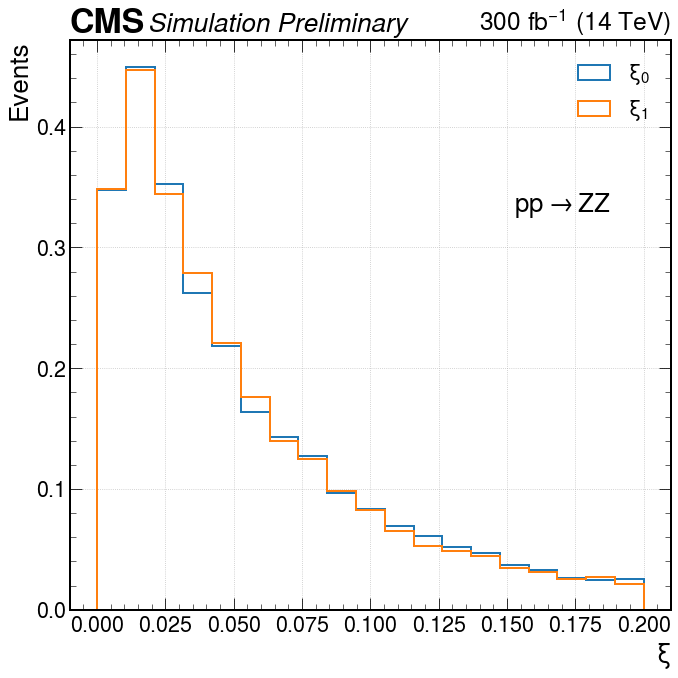

In [34]:
lumi=300. #1/fb
xsec=0.01233 #fb
if vb=='Zgamma': xsec=0.03566
df['w']=lumi*xsec/ngen

#xi distribution
fig,ax=plt.subplots()
cts,_,_=ax.hist(df['csi0'],weights=df['w'],bins=np.linspace(0,0.2,20),histtype='step',label=r'$\xi_0$',linewidth=2)
ax.hist(df['csi1'],weights=df['w'],bins=np.linspace(0,0.2,20),histtype='step',label=r'$\xi_1$',linewidth=2)
ymax=np.max(cts)
ax.plot([0.02,0.02],[ymax,ymax]) #,color='gray')
ax.plot([0.15,0.15],[ymax,ymax]) #,color='gray')
ax.legend()
ax.set_xlabel(r'$\xi$')
ax.set_ylabel('Events')
ax.grid()
hep.cms.label(loc=0,
              data=False,
              ax=ax,
              rlabel=r'300 $fb^{-1}$ (14 TeV)')
ax.text(0.9,0.7,vbtitle,horizontalalignment='right',transform=ax.transAxes)
plt.tight_layout()
plt.savefig('{}/xi_{}.png'.format(_plotsdir,vb))
plt.show()


#kinematics
for v,vtitle,bins in [ ('zpt',r'$p_{T}(Z)$ [GeV]',np.linspace(0,500,20)),
                       ('mpp',r'Di-proton mass [GeV]',np.linspace(150,2000,20)),
                       ('mmiss',r'Missing mass [GeV]',np.linspace(0,200,20)),
                      ]:
    fig,ax=plt.subplots()
    ax.hist(df[v],weights=df['w'],bins=bins,histtype='step',linewidth=2,label='Inclusive')
    mask=(df['csi0']>0.02) & (df['csi1']>0.02) 
    mask=(df['csi0']<0.15) & (df['csi1']<0.15) 
    ax.hist(df[mask][v],weights=df[mask]['w'],bins=bins,linewidth=2,label=r'0.02$<\xi<$0.15')
    ax.set_xlabel(vtitle)
    ax.set_ylabel('Events')
    ax.legend()
    ax.grid()
    ax.set_yscale('log')
    hep.cms.label(loc=0,
                  data=False,
                  ax=ax,
                  rlabel=r'300 $fb^{-1}$ (14 TeV)')
    ax.text(0.9,0.7,vbtitle,horizontalalignment='right',transform=ax.transAxes)
    plt.tight_layout()
    plt.savefig('{}/{}_{}.png'.format(_plotsdir,v,vb))
    plt.close()

In [35]:
mask=(df['csi0']>0.02) & (df['csi1']>0.02) 
mask=(df['csi0']<0.15) & (df['csi1']<0.15) 

print('NZ=',df['w'].sum(),'NZ+2p=',df[mask]['w'].sum())

NZ= 2.804837736634076 NZ+2p= 2.164611400041607


| Process | N(Z) | N(Z+2p) |
| ------------- |:-------------:| -----:|
| ZZ | 2.8 | 2.2 |
| Z$\gamma$ | 4.4 | 3.2 |